# Rule: **base_network**

**Summary**

Creates the network topology from a ENTSO-E map extract as a PyPSA network.

**Outputs:**

- resources/networks/`base.nc`
- resources/regions_onshore
- resources/regions_offshore


**Comments:**

In [1]:
import pypsa
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml
import os 
import sys


##### Local funs
funs_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'local_funs'))
sys.path.append(funs_path)

from fun_map_add_features import fun_map_add_features
from fun_map_network_geometry import fun_map_network_geometry


##### Warnings setup
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



In [2]:
######################################## Parameters

with open('../config.yaml', 'r') as configfile:
    config = yaml.safe_load(configfile)

rootpath = config['notebook']['rootpath']
prefix = config['notebook']['prefix']
name = config['notebook']['name']

boundaries_onshore = config['map']['boundaries_onshore']
boundaries_offshore = config['map']['boundaries_offshore']

## `base.nc`

In [3]:
file = f'base.nc'
path = f'{rootpath}/resources/{prefix}/{name}/networks/'

n = pypsa.Network(path+file)

n

INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, shapes, transformers


PyPSA Network 'PyPSA-Spain'
Components:
 - Bus: 1109
 - Carrier: 2
 - Line: 1474
 - Link: 1
 - Shape: 1100
 - Transformer: 84
Snapshots: 8760

Text(0.5, 1.0, 'base.nc')

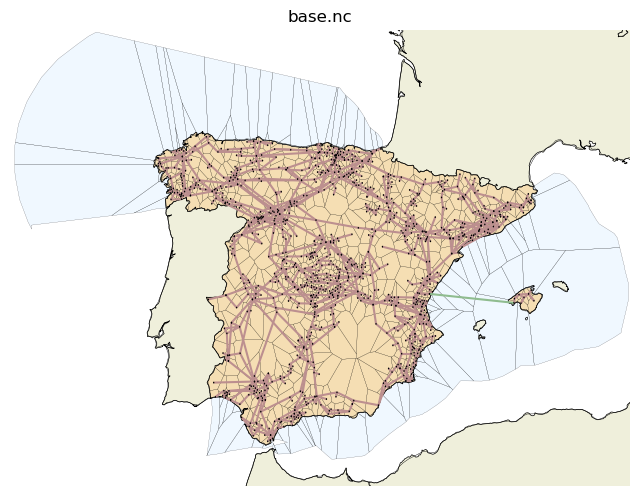

In [4]:
########## Plot the network

bus_sizes = 0.0005
bus_colors = 'black'


fig_size = [8,12]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network
n.plot(ax=ax, bus_sizes=bus_sizes, bus_colors=bus_colors, boundaries=boundaries_offshore)

### Add network geometry
fun_map_network_geometry(n, ax, domain='both')

### Add features
fun_map_add_features(ax)


ax.set_title('base.nc')

### Variable: `n.buses`

`n.buses` includes 'x' and 'y' coordinates.

In [5]:
n.buses.head()

,v_nom,symbol,under_construction,tags,x,y,country,onshore_bus,substation_lv,substation_off,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,,,,,,,
7928,380.0,joint,False,,-2.671051,43.171132,ES,True,False,False,,AC,,1.0,0.0,inf,PQ,,
923,220.0,Substation,False,"""TSO""=>"""", ""oid""=>""34182"", ""country""=>""ES"", ""v...",-5.493164,36.426808,ES,True,True,True,,AC,,1.0,0.0,inf,PQ,,
924,220.0,Substation,True,"""TSO""=>"""", ""oid""=>""37084"", ""country""=>""ES"", ""v...",-5.539856,36.106815,ES,True,False,False,,AC,,1.0,0.0,inf,PQ,,
927,380.0,Substation,False,"""TSO""=>"""", ""oid""=>""33728"", ""country""=>""ES"", ""v...",-5.456085,36.136766,ES,True,False,True,,AC,,1.0,0.0,inf,PQ,,
926,220.0,Substation,False,"""TSO""=>"""", ""oid""=>""33728"", ""country""=>""ES"", ""v...",-5.456085,36.136766,ES,True,True,False,,AC,,1.0,0.0,inf,PQ,,


Buses are classified into *Substation*, *joint* and others according to column `symbol`. The share of each type is as follows:

In [6]:
n.buses['symbol'].value_counts(normalize=True)*100

symbol
Substation                    59.963931
joint                         39.855726
Other or not listed            0.090171
Substations + Power Plants     0.090171
Name: proportion, dtype: float64

### Variable: `n.carriers`

In [7]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
AC,0.0,,,inf,0.0
DC,0.0,,,inf,0.0


### Variable: `n.lines`

The distribution of line lengths is as follows:

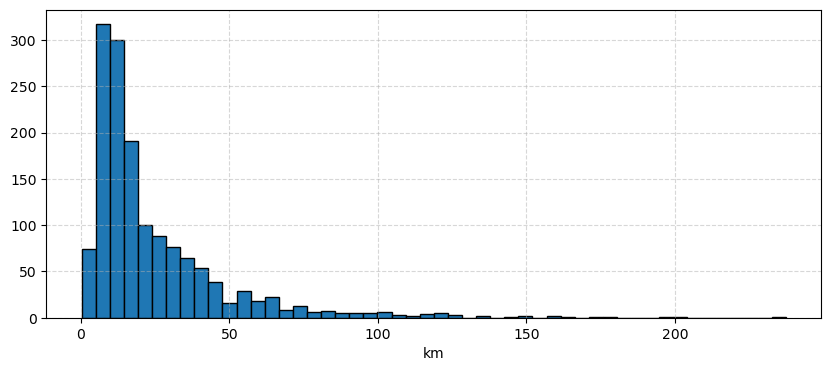

In [8]:
bins = 50


fig_size = [10,4]

fig, ax = plt.subplots(figsize=fig_size)


ax.hist(n.lines['length'], bins=bins, edgecolor='black')

ax.set_xlabel('km')
ax.grid(True, linestyle='--', alpha=0.5)


### Variable: `n.links`

In [9]:
n.links

,bus0,bus1,length,underground,under_construction,tags,geometry,carrier,p_min_pu,p_nom,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
5640,1422,1638,234.733219,False,False,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""32590"", ""...","LINESTRING(2.48932993486183 39.561252379133,1....",DC,-1.0,400.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


## `regions_onshore.geojson` , `regions_offshore.geojson`

Contains onshore and offshore regions information stored in `n.shapes` and `buses` ('x' and 'y' coordinates).

Compare `regions_onshore.geojson`, `regions_offshore.geojson` and `n.shapes` (the latter includes two more rows corresponding to the country and offshore areas):

In [10]:
file_onshore = 'regions_onshore.geojson'
file_offshore = 'regions_offshore.geojson'
path = f'{rootpath}/resources/{prefix}/{name}/'

gdf_onshore = gpd.read_file(path+file_onshore)
gdf_offshore = gpd.read_file(path+file_offshore)

In [11]:
gdf_onshore

,name,x,y,country,geometry
0,2782,-0.955811,41.102121,ES,"POLYGON ((-0.93186 41.21896, -0.77596 41.09969..."
1,2646,-5.037231,41.169351,ES,"POLYGON ((-5.07744 40.9717, -5.19283 40.97366,..."
2,2637,-5.310516,41.626735,ES,"POLYGON ((-5.36645 41.70053, -5.35791 41.7017,..."
3,2638,-5.269318,41.697526,ES,"POLYGON ((-5.16728 41.6002, -5.17156 41.59325,..."
4,2639,-5.145721,41.739553,ES,"POLYGON ((-5.08092 41.82179, -5.0264 41.73258,..."
...,...,...,...,...,...
987,7242,1.213958,41.211256,ES,"POLYGON ((1.27532 41.12799, 1.18336 41.15373, ..."
988,7113,0.438786,41.136698,ES,"POLYGON ((0.44787 40.94576, 0.14361 40.89618, ..."
989,7659,-4.563291,39.865255,ES,"POLYGON ((-4.48061 39.70483, -4.60413 39.6865,..."
990,8176,-7.453717,42.973817,ES,"POLYGON ((-7.73486 43.10546, -7.73138 43.12362..."


In [12]:
gdf_offshore

,name,x,y,country,geometry
0,927,-5.456085,36.136766,ES,"POLYGON ((-5.3915 36.10913, -5.39121 36.10619,..."
1,930,-5.383301,36.178900,ES,"MULTIPOLYGON (((-5.03238 36.11751, -5.04196 36..."
2,931,-5.012512,36.473202,ES,"POLYGON ((-4.80053 35.82539, -4.99244 36.06718..."
3,939,-4.726868,36.503013,ES,"POLYGON ((-4.55231 36.51258, -4.05551 35.97954..."
4,1004,-6.112518,36.557085,ES,"POLYGON ((-6.27751 36.58273, -6.26985 36.59823..."
...,...,...,...,...,...
101,2835,-6.431122,43.282204,ES,"POLYGON ((-6.5023 43.55557, -6.60084 43.55833,..."
102,2836,-6.221008,43.529634,ES,"POLYGON ((-6.62184 45.46416, -6.26815 45.4029,..."
103,2838,-6.005402,43.547553,ES,"POLYGON ((-6.26815 45.4029, -5.78245 45.31877,..."
104,2841,-5.870819,43.499756,ES,"POLYGON ((-5.87913 43.68971, -5.86264 43.64087..."


In [13]:
n.shapes

,geometry,idx,type,component
Shape,,,,
0,"MULTIPOLYGON (((-7.69616 43.73151, -7.69156 43...",ES,country,
1,"MULTIPOLYGON (((-2.04444 43.8, -1.925 43.72917...",ES,offshore,
2,"POLYGON ((-0.93186 41.21896, -0.77596 41.09969...",2782,onshore,Bus
3,"POLYGON ((-5.07744 40.9717, -5.19283 40.97366,...",2646,onshore,Bus
4,"POLYGON ((-5.36645 41.70053, -5.35791 41.7017,...",2637,onshore,Bus
...,...,...,...,...
1095,"POLYGON ((-6.5023 43.55558, -6.60084 43.55833,...",2835,offshore,Bus
1096,"POLYGON ((-6.62184 45.46416, -6.26815 45.4029,...",2836,offshore,Bus
1097,"POLYGON ((-6.26815 45.4029, -5.78245 45.31877,...",2838,offshore,Bus
